In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.interpolate import interp1d

In [2]:
class Analysis_NetCDF:
    
    def __init__(self, ds, IMAX = 168, JMAX = 288, KCMAX = 80):
        
        self.ds = ds
        self.IMAX = IMAX
        self.JMAX = JMAX
        self.KCMAX = KCMAX
        
    def diff(self, Analysis_NetCDF_1, var):
        
        stats = {}
        stats['L2 norm diff'] = np.linalg.norm(self.ds[var]- Analysis_NetCDF_1.ds[var])
        stats['L2 norm diff per column'] = stats['L2 norm diff'] / ((self.IMAX + 1) * (self.JMAX + 1))
        
        if(len(self.ds[var].shape) == 3):
            stats['L2 norm diff per cell'] = stats['L2 norm diff'] / ((self.IMAX + 1) * (self.JMAX + 1) * (self.KCMAX + 1))
            stats['L2 norm diff every z-level'] = np.linalg.norm(self.ds[var]- Analysis_NetCDF_1.ds[var], axis = (1,2))
            stats['L2 norm diff every z-level per cell'] = stats['L2 norm diff every z-level'] / ((self.IMAX + 1) * (self.JMAX + 1))
        elif(len(self.ds[var].shape) == 2):
            stats['L2 norm diff per cell'] = stats['L2 norm diff'] / ((self.IMAX + 1) * (self.JMAX + 1))
        else:
            raise ValueError("Something wrong with dimensions of {var}, it should be either 2 or 3.")
        
        return stats
    
    def contours(self, contour_val, var, z, thick, kind = 'linear'):
      
        def find_straddle(value, array):

            for i in range(len(array)-1):
   
                if array[i] >= value and array[i+1] <= value: 
                    return i, array[i], array[i+1]
            
            return np.nan, np.nan, np.nan
        
        def z_contour_val_for_column(index, high, low, value, z_var, kind = 'linear'):
        
            if index is not np.nan and low is not np.nan and high is not np.nan:
                
                f = interp1d(np.array([high, low]), np.array([z_var[index], z_var[index+1]]), kind = kind)
                z_contour_val = f(value)
                
            else:
                
                z_contour_val = np.nan
    
            return z_contour_val
        
        variable_values = self.ds.variables[var].values
        thick_values = self.ds.variables[thick].values
        z_values = self.ds.variables[z].values
        shape_z, shape_y, shape_x = variable_values.shape

        var_new = f'{var}_contour_{contour_val}'
        variable_new = np.zeros((shape_y, shape_x))
    
        for j in range(shape_y):
            for i in range(shape_x):
                
                index, high, low = find_straddle(contour_val, variable_values[: ,j, i])
                z = z_contour_val_for_column(index, high, low, contour_val, z_values)
                variable_new[j, i] = thick_values[j, i] * z
        
        self.ds[var_new] = ([self.ds[var].dims[1], self.ds[var].dims[2]], 
                               variable_new)
        self.ds[var_new].attrs['Base variable'] = var
        
        if 'modifications' in self.ds[var].attrs:
            self.ds[var_new].attrs['modifications'] = self.ds[var].attrs['modifications'] + \
                                                                f', Contour {contour_val}' 
        else:
            self.ds[var_new].attrs['modifications'] = f', Contour {contour_val}'

In [3]:
### Reading a netcdf file
ds = xr.open_dataset('grl10_bm3_paleo17a/grl10_bm3_paleo17a0007.nc')
ds1 = xr.open_dataset('grl10_bm3_paleo17a_BH_TR_0/grl10_bm3_paleo17a0007.nc')
ds2 = xr.open_dataset('grl10_bm3_paleo17a_BH_0/grl10_bm3_paleo17a0007.nc')
ds3 = xr.open_dataset('grl10_bm3_paleo17a_TRAMP_0/grl10_bm3_paleo17a0007.nc')

In [4]:
AN = Analysis_NetCDF(ds)
AN1 = Analysis_NetCDF(ds1)
AN2 = Analysis_NetCDF(ds2)
AN3 = Analysis_NetCDF(ds3)

In [5]:
AN1.contours(100, 'age_c', 'sigma_level_c', 'H', kind = 'linear')
AN1.contours(1000, 'age_c', 'sigma_level_c', 'H', kind = 'linear')

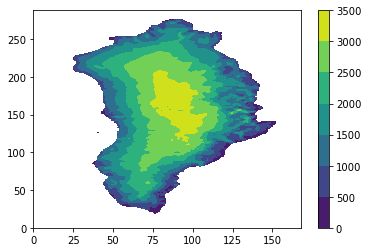

In [6]:
plt.contourf(AN1.ds.variables['age_c_contour_100'])
plt.colorbar()

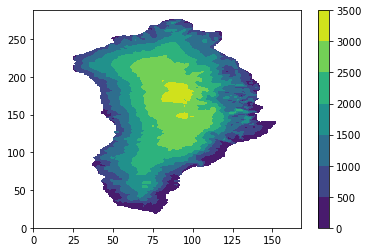

In [7]:
plt.contourf(AN1.ds.variables['age_c_contour_1000'])
plt.colorbar()

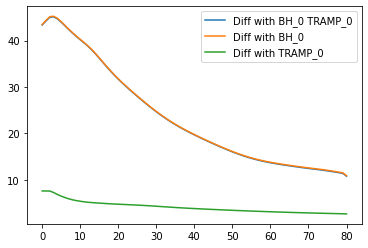

In [8]:
plt.plot(AN.diff(AN1, 'age_c')['L2 norm diff every z-level per cell'], label = 'Diff with BH_0 TRAMP_0')
plt.plot(AN.diff(AN2, 'age_c')['L2 norm diff every z-level per cell'], label = 'Diff with BH_0')
plt.plot(AN.diff(AN3, 'age_c')['L2 norm diff every z-level per cell'], label = 'Diff with TRAMP_0')
plt.legend()

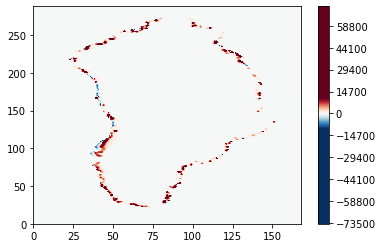

In [9]:
plt.contourf(AN.ds['age_c'][-1]-AN1.ds['age_c'][-1], levels = 1000, cmap = 'RdBu_r', vmin = -10000, vmax = 10000)
plt.colorbar()

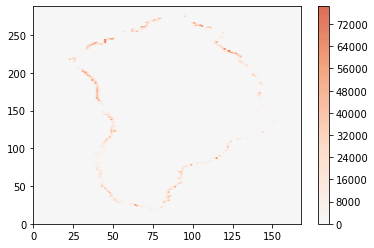

In [10]:
plt.contourf(AN.ds['age_c'][-1], levels = 100, cmap = 'RdBu_r', vmin = -140000, vmax = 140000)
plt.colorbar()

In [11]:
class DataCleaner:
    
    def __init__(self, ds):
        
        self.ds = ds
        
    def clean_entire_nan_columns_non_zero_thick(self, var, thick_var, replace_with = 0.0):
    
        # For interpolated variables, thick_var has to be some interpolated thickness, otherwise shapes won't match
        
        variable = self.ds.variables[var]
        thick = self.ds.variables[thick_var]
        
        shape_z, shape_x, shape_y = variable.shape

        sum_nan_columns = np.sum(np.isnan(variable), axis = 0)
        
        for i in range(shape_x):
            for j in range(shape_y):
                if sum_nan_columns[i,j] == shape_z and thick[i,j] == 0.0:
                    variable[:,i,j] = replace_with
                    
        self.ds.variables[var][:] = variable
        
        if 'modifications' in self.ds[var].attrs:
            
            self.ds[var].attrs['modifications'] = self.ds[var].attrs['modifications'] + \
                                                                ', Clear all NaN columns'
        else:
            
            self.ds[var].attrs['modifications'] = 'Clear all NaN columns'
                   
    def nan_stats(self, var, thick_var):
        
        # For interpolated variables, thick_var has to be some interpolated thickness, otherwise shapes won't match
        
        variable = self.ds.variables[var]
        shape_z, shape_x, shape_y = variable.shape
        num_nan_columns = 0
        flag_nan_columns = np.zeros((shape_x, shape_y), dtype = int)
        
        sum_nan_columns = np.sum(np.isnan(variable), axis = 0)
        flag_nan_columns = sum_nan_columns == shape_z
        num_nan_columns = np.sum(flag_nan_columns)
        
        flag_non_zero_thick = self.ds.variables[thick_var] > 0.0

        flag_nan_columns_nonzero_thick = np.logical_and(flag_non_zero_thick, flag_nan_columns)
        num_nan_columns_nonzero_thick = np.sum(flag_nan_columns_nonzero_thick)
        
        num_nan_z_levels = np.sum(np.isnan(variable), axis = (1,2))
        
        flag_nan = np.isnan(variable)
        
        ### Pad a with 0 at both sides for edge cases when a starts or ends with 1
        ### See answer by Psidom - 
        ### https://stackoverflow.com/questions/54446907/how-to-calculate-numbers-of-uninterrupted-repeats-in-an-array-in-python/54447096#54447096

        ### In our case, pad only in the z-dimension
        temp = np.pad(flag_nan, pad_width=((1, 1), (0, 0), (0, 0)), mode='constant')
        flag_num_nan_patches_columns = np.sum(np.logical_xor(temp[1:], temp[:-1]) == True, axis = 0) / 2
        flag_num_nan_patches_columns = flag_num_nan_patches_columns.astype(int)
        statsDict = {}
        flagsDict = {}
        
        statsDict['Total NaNs'] = np.count_nonzero(np.isnan(variable))
        statsDict['Total NaN columns'] = num_nan_columns
        statsDict['Total NaN columns with non-zero ice thickness'] = num_nan_columns_nonzero_thick
        statsDict['Total NaN on different z-levels'] = num_nan_z_levels
        
        flagsDict['Flag for all NaN columns'] = flag_nan_columns
        flagsDict['Total NaN in each column'] = sum_nan_columns
        flagsDict['Flag for all NaN columns, non-zero thick'] = flag_nan_columns_nonzero_thick
        flagsDict['Flag for num of contiguous NaN patches in cols'] = flag_num_nan_patches_columns
        
        return statsDict, flagsDict
    
    def clean_middle_nans(self, var, kind = 'linear'):
        
        def middle_clean_column(z, 
                                #z_interp,
                                var_column, kind = 'linear'):

            start = np.where(~np.isnan(var_column))[0][0]
            end = np.where(~np.isnan(var_column))[0][-1]

            z_middle = z[start:end+1]

            var_column_copy = np.copy(var_column)

            var_column_middle = var_column_copy[start:end+1]

            #z_interp_middle = z_interp[z_interp >= z_middle[0]]
            #z_interp_middle = z_interp_middle[z_interp_middle <= z_middle[-1]]

            flag_not_nan_middle = ~np.isnan(var_column_middle)

            f = interp1d(z_middle[flag_not_nan_middle], var_column_middle[flag_not_nan_middle], kind = kind)

            var_column_copy[start:end+1] = f(z_middle) # f(z_interp_middle)

            return var_column_copy
        
        variable_values = self.ds.variables[var].values
        
        shape_z, shape_x, shape_y = variable_values.shape
        
        var_middle_clean = var + '_middle_clean'
        
        for i in range(shape_x):
            for j in range(shape_y):
                
                if np.sum(np.isnan(variable_values[:,i,j])) in [0, shape_z - 1, shape_z]:
                    pass
                else:
                    variable_values[:,i,j] = middle_clean_column(np.arange(shape_z), variable_values[:,i,j])
    
        self.ds.variables[var][:] = variable_values
    
        if 'modifications' in self.ds[var].attrs:
            
            self.ds[var].attrs['modifications'] = self.ds[var].attrs['modifications'] + \
                                                                f', Clean middle columns using {kind} interpolation'
        else:
            
            self.ds[var].attrs['modifications'] = f'Clean middle columns using {kind} interpolation'
        

In [12]:
class DataInterpolator(DataCleaner):
    
    def __init__(self, ds, 
                 model_x, model_y, model_KCMAX, model_exp_a = 2.0,
                 method = 'nearest_neighbor'):
        
        super().__init__(ds)
        
        self.ds = ds
        
        self.model_x = model_x
        self.model_y = model_y
        self.model_KCMAX = model_KCMAX
        self.model_exp_a = model_exp_a
        self.method = method
        
        if self.method != 'nearest_neighbor':
            raise NotImplementedError("Only nearest_neighbor interpolation is available.")

    def expand_dims(self):
        
        self.ds_expanded = xr.Dataset()
        
        Dict = {}
        Dict['number of model grid points in x-direction'] = self.model_x.shape[0]
        Dict['number of model grid points in y-direction'] = self.model_y.shape[0]
        Dict['number of vertical model layers'] = self.model_KCMAX + 1
        
        self.ds_expanded = self.ds_expanded.expand_dims(Dict)

    def add_model_variables(self):
        
        x_model_mesh, y_model_mesh = np.meshgrid(self.model_x, self.model_y)
        
        self.ds_expanded['x_model'] = (['number of model grid points in x-direction', 
                               'number of model grid points in y-direction'], x_model_mesh.T)
        self.ds_expanded['y_model'] = (['number of model grid points in x-direction', 
                               'number of model grid points in y-direction'], y_model_mesh.T)
        self.ds_expanded['zeta_c_model'] = (['number of vertical model layers'], np.linspace(0.,1.,self.model_KCMAX+1))
        
        zeta_c_model_exp = (np.exp(self.model_exp_a*self.ds_expanded['zeta_c_model'])-1) \
                          /(np.exp(self.model_exp_a)-1)
        
        self.ds_expanded['zeta_c_exp_model'] = (['number of vertical model layers'], zeta_c_model_exp.values)
        self.ds_expanded['zeta_c_exp_model'].attrs['Exp parameter'] = self.model_exp_a
        
    def unfreeze_ds(self):
        ### ds.dim will show that the dataset is frozen and we cannot add more dimensions
        ### Instead we will create a new dataset
        
        ds_unfrozen = self.ds_expanded.copy()
        
        ds_unfrozen.attrs = self.ds.attrs

        for key, value in self.ds.variables.items():
            ds_unfrozen[key] = value

        self.ds = ds_unfrozen.copy() 
        
    def add_top_layer(self, var):
        
        ### This operation only makes sense for original variables
        ### You should add top layer and then interpolate in the vertical
        
        variable = self.ds.variables[var]
        
        shape_z, shape_x, shape_y = variable.shape
        
        var_new = var + '_TopLayerAdded'
        
        variable_new = np.zeros((shape_z+1, shape_x, shape_y), dtype = float)
        variable_new[1:] = np.copy(variable.values)
        
        self.ds[var_new] = (['number of vertical layers with top layer added', 
                                'number of grid points in x-direction', 
                                'number of grid points in y-direction'], 
                               variable_new)      

        self.ds[var_new].attrs['Base variable'] = var
        
        if 'modifications' in self.ds[var].attrs:
            
            self.ds[var_new].attrs['modifications'] = self.ds[var].attrs['modifications'] + \
                                                                ', Top layer added'
        else:
            
            self.ds[var_new].attrs['modifications'] = 'Top layer added'
            
    def reverse_vertically(self, var):
        
        ### Only do this after adding top layer
        
        variable = self.ds.variables[var]
        
        shape_z, shape_x, shape_y = variable.shape
        
        var_new = var + '_Reversed'
        
        variable_new = np.zeros((shape_z, shape_x, shape_y), dtype = float)
        variable_new = np.copy(variable.values[::-1])
        
        self.ds[var_new] = (['number of vertical layers with top layer added', 
                                'number of grid points in x-direction', 
                                'number of grid points in y-direction'], 
                               variable_new)      

        self.ds[var_new].attrs['Base variable'] = var
        
        if 'modifications' in self.ds[var].attrs:
            
            self.ds[var_new].attrs['modifications'] = self.ds[var].attrs['modifications'] + \
                                                                ', Reversed vertically'
        else:
            
            self.ds[var_new].attrs['modifications'] = 'Reversed vertically'
            
    def NN_2D(self):
        
        self.data_x_closest_indices = np.zeros(self.model_x.shape, dtype = int)
        self.data_y_closest_indices = np.zeros(self.model_y.shape, dtype = int)
    
        for i in range(self.model_x.shape[0]):
            
            self.data_x_closest_indices[i] = np.abs(self.model_x[i] - self.ds['x'][:,0]).argmin()
        
        for j in range(self.model_y.shape[0]):

            self.data_y_closest_indices[j] = np.abs(self.model_y[j] - self.ds['y'][0,:]).argmin()

        self.ds['thick_2D_interp'] = (['number of model grid points in x-direction', 
                                       'number of model grid points in y-direction'], 
                                      self.ds.variables['thick'].values[np.ix_(self.data_x_closest_indices, self.data_y_closest_indices)])

        self.ds['thick_2D_interp'].attrs['Base variable'] = 'thick'

        if 'modifications' in self.ds['thick'].attrs:
            
            self.ds['thick_2D_interp'].attrs['modifications'] = self.ds['thick'].attrs['modifications'] + \
                                                                ', 2D Nearest Neighbor Interpolation'
        else:
            
            self.ds['thick_2D_interp'].attrs['modifications'] = '2D Nearest Neighbor Interpolation'
        
    def NN_2D_var(self, var):
        
        variable = self.ds.variables[var]
        
        shape_z, shape_x, shape_y = variable.shape
        
        var_interp = var + '_2D_interp'
        
        variable_interp = variable.values[np.ix_(range(shape_z), self.data_x_closest_indices, self.data_y_closest_indices)] 
        
        self.ds[var_interp] = (['number of vertical layers with top layer added', 
                                'number of model grid points in x-direction', 
                                'number of model grid points in y-direction'], 
                               variable_interp)
        
        self.ds[var_interp].attrs['Base variable'] = var
        
        if 'modifications' in self.ds[var].attrs:
            
            self.ds[var_interp].attrs['modifications'] = self.ds[var].attrs['modifications'] + \
                                                                ', 2D Nearest Neighbor Interpolation'
        else:
            
            self.ds[var_interp].attrs['modifications'] = '2D Nearest Neighbor Interpolation'
            
    def z_interpolation_middle_columns(self, var, kind = 'linear'):
        
        ### Assumed that the middle of the columns have no NaNs

        def interp_one_column_middle(z, z_interp, var_column, kind = 'linear'):

            var_column_interp = np.empty(len(z_interp))
            var_column_interp[:] = np.NaN
            
            start = np.where(~np.isnan(var_column))[0][0]
            end = np.where(~np.isnan(var_column))[0][-1]

            z_middle = z[start:end+1]

            var_column_middle = var_column[start:end+1]

            z_interp_middle = z_interp[z_interp >= z_middle[0]]
            start_interp = len(z_interp) - len(z_interp_middle)
            z_interp_middle = z_interp_middle[z_interp_middle <= z_middle[-1]]
            end_interp = len(z_interp_middle) + start_interp - 1

            f = interp1d(z_middle, var_column_middle, kind = kind)

            var_column_interp[start_interp:end_interp+1] = f(z_interp_middle)

            return var_column_interp
        
        variable_values = self.ds.variables[var].values
        
        shape_z, shape_x, shape_y = variable_values.shape
        
        var_interp = var + f'_z_interp_{kind}'
        
        variable_interp_values = np.empty((self.model_KCMAX + 1, shape_x, shape_y), dtype = float)
        variable_interp_values[:] = np.NaN
        
        zeta_c_data = np.linspace(0., 1., len(self.ds['number of vertical layers with top layer added']))
        zeta_c_model = self.ds['zeta_c_exp_model'].values
        
        for i in range(shape_x):
            for j in range(shape_y):
                
                if np.sum(np.isnan(variable_values[:,i,j])) in [shape_z - 1, shape_z]:
                    pass
                else:
                    variable_interp_values[:,i,j] = interp_one_column_middle(zeta_c_data,
                                                                            zeta_c_model, 
                                                                            variable_values[:,i,j], 
                                                                            kind = kind)
        
        self.ds[var_interp] = (['number of vertical model layers', 
                                'number of model grid points in x-direction', 
                                'number of model grid points in y-direction'], 
                                variable_interp_values)
        
        if 'modifications' in self.ds[var].attrs:
            
            self.ds[var_interp].attrs['modifications'] = self.ds[var].attrs['modifications'] + \
                                                                f', z {kind} interpolation'
        else:
            
            self.ds[var_interp].attrs['modifications'] = f'z {kind} interpolation'
         
    def eval_misfit(self, ds_model):
        ### Assumed that we have self.ds['age_norm_TopLayerAdded_2D_interp_z_interp_linear'].values
        
        ### We correct the following quirks
        ### age_data_interp is shaped (81,169,289) for a 10 km grid.
        ### age_model is shaped (81,289,169) for a 10 km grid.
        ### misfit is shaped (81,289,169).
        
        age_data_interp = np.transpose(self.ds['age_norm_TopLayerAdded_Reversed_2D_interp_z_interp_linear'].values, (0,2,1))
        age_model = ds_model['age_c'].values

        self.ds['age_misfit'] = (['number of vertical model layers',
                                  'number of model grid points in y-direction', 
                                  'number of model grid points in x-direction'], 
                                  age_data_interp-age_model)
        
        self.ds['age_misfit'].attrs['modifications'] = f"ds_model['age_c'].values-np.transpose(self.ds['age_norm_TopLayerAdded_Reversed_2D_interp_z_interp_linear'].values, (0,2,1))[::-1]"
        age_misfit = self.ds['age_misfit'].values
        self.age_misfit_statsDict = {}
        
        self.age_misfit_statsDict['Number of NaNs'] = np.count_nonzero(np.isnan(age_misfit))
        self.age_misfit_statsDict['Number of NaNs in each layer'] = np.count_nonzero(np.isnan(age_misfit), axis=(1,2))
        self.age_misfit_statsDict['Number of not NaNs in each layer'] = np.count_nonzero(~np.isnan(age_misfit), axis=(1,2))
        self.age_misfit_statsDict['Number of NaNs in each column as percentage of cells at each level'] \
                                = np.count_nonzero(np.isnan(age_misfit), axis=(1,2)) / (self.model_x.shape[0] * self.model_y.shape[0]) * 100
        self.age_misfit_statsDict['Number of not NaNs in each column as percentage of cells at each level'] \
                                = np.count_nonzero(~np.isnan(age_misfit), axis=(1,2)) / (self.model_x.shape[0] * self.model_y.shape[0]) * 100
        self.age_misfit_statsDict['Number of not NaNs in each column as percentage of not NaNs in top layer'] \
                                = np.count_nonzero(~np.isnan(age_misfit), axis=(1,2)) / self.age_misfit_statsDict['Number of not NaNs in each layer'][-1] * 100
        self.age_misfit_statsDict['Misfit norm in each layer normalized by number of not NaNs in each layer'] \
                                = np.array([np.linalg.norm(age_misfit[i][~np.isnan(age_misfit[i])]) for i in range(age_misfit.shape[0])]) \
                                  / self.age_misfit_statsDict['Number of not NaNs in each layer']
        
        temp = np.zeros((289,169))
        for j in range(self.model_y.shape[0]):
            for i in range(self.model_x.shape[0]):
                ### 1e-10 in denominator added to prevent division by 0, doesn't change results much.
                temp[j, i] =  np.linalg.norm(age_misfit[:,j,i][~np.isnan(age_misfit[:,j,i])]) / (1e-10 + np.count_nonzero(~np.isnan(age_misfit[:,j,i])))

        
        self.age_misfit_statsDict['Misfit norm in each column normalized by number of not NaNs in that column'] = np.copy(temp)
        
    def contours(self, contour_val, var, z_var, thick_var, kind = 'linear'):
        
        ### Assumed that z_var starts from 0 and goes to 1
        ### Assumed that z_var indeed corresponds to z axis of var
        ### Which means that if var comes from the data, it has to be reversed
        ### Since the data is stored from top to bottom (1 to 0 in model co-ordinates)
        ### To get the contours we need to interpolate in each column
        ### var is shaped (shape_z,shape_x,shape_y)
        ### thick_var is shaped (shape_x, shape_y)
        ### newly formed contour variable shaped (shape_x, shape_y)
      
        def find_straddle(value, array):

            for i in range(len(array)-1):
   
                if array[i] >= value and array[i+1] <= value: 
                    return i, array[i], array[i+1]
            
            return np.nan, np.nan, np.nan
        
        def z_contour_val_for_column(index, high, low, value, z_var, kind = 'linear'):
        
            if index is not np.nan and low is not np.nan and high is not np.nan:
                
                f = interp1d(np.array([high, low]), np.array([z_var[index], z_var[index+1]]), kind = kind)
                z_contour_val = f(value)
                
            else:
                
                z_contour_val = np.nan
    
            return z_contour_val
        
        variable_values = self.ds.variables[var].values
        thick_values = self.ds.variables[thick_var].values
        z_values = self.ds.variables[z_var].values
        shape_z, shape_x, shape_y = variable_values.shape

        var_new = f'{var}_contour_{contour_val}'
        variable_new = np.zeros((shape_x, shape_y))
    
        for i in range(shape_x):
            for j in range(shape_y):
                
                index, high, low = find_straddle(contour_val, variable_values[: ,i, j])
                z = z_contour_val_for_column(index, high, low, contour_val, z_values)
                variable_new[i, j] = thick_values[i, j] * z
        
        self.ds[var_new] = ([self.ds[var].dims[1], self.ds[var].dims[2]], 
                               variable_new)
        self.ds[var_new].attrs['Base variable'] = var
        
        if 'modifications' in self.ds[var].attrs:
            self.ds[var_new].attrs['modifications'] = self.ds[var].attrs['modifications'] + \
                                                                f', Contour {contour_val}' 
        else:
            self.ds[var_new].attrs['modifications'] = f', Contour {contour_val}'

In [13]:
### Reading a netcdf file
data = xr.open_dataset('RRRAG4_Greenland_1993_2013_01_age_grid.nc')

In [14]:
x_model_10km = np.arange(-72.,97.,1.)*10
y_model_10km = np.arange(-345.,-56.,1.)*10
KCMAX = 80

In [15]:
DI = DataInterpolator(data, x_model_10km, y_model_10km, KCMAX)
DI.expand_dims()
DI.add_model_variables()
DI.unfreeze_ds()
DI.add_top_layer('age_norm')
DI.reverse_vertically('age_norm_TopLayerAdded')
DI.NN_2D()
DI.NN_2D_var('age_norm_TopLayerAdded_Reversed')
DI.clean_middle_nans('age_norm_TopLayerAdded_Reversed_2D_interp', kind = 'linear')
DI.z_interpolation_middle_columns('age_norm_TopLayerAdded_Reversed_2D_interp', kind = 'linear')

In [16]:
DI.eval_misfit(ds1)

In [17]:
DI.contours(100, 
            'age_norm_TopLayerAdded_Reversed_2D_interp_z_interp_linear',
            'zeta_c_exp_model',
            'thick_2D_interp',
            kind = 'linear')

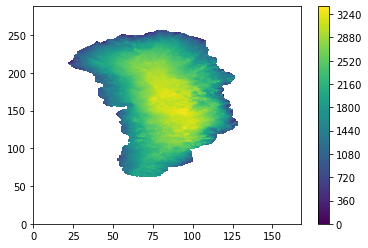

In [18]:
plt.contourf(DI.ds['age_norm_TopLayerAdded_Reversed_2D_interp_z_interp_linear_contour_100'].T, levels = 100)
plt.colorbar()

In [19]:
DI.nan_stats('age_norm_TopLayerAdded_Reversed_2D_interp_z_interp_linear', 'thick_2D_interp')

({'Total NaNs': 3178038,
  'Total NaN columns': <xarray.Variable ()>
  array(36192),
  'Total NaN columns with non-zero ice thickness': <xarray.Variable ()>
  array(5401),
  'Total NaN on different z-levels': <xarray.Variable (number of vertical model layers: 81)>
  array([47312, 47312, 47312, 47312, 47312, 47312, 47312, 47312, 47312,
         47312, 44948, 44948, 44948, 44948, 44948, 44948, 44948, 42606,
         42606, 42606, 42606, 42606, 42606, 39520, 39520, 39520, 39520,
         39520, 39520, 37761, 37761, 37761, 37761, 36957, 36957, 36957,
         36957, 36957, 36651, 36651, 36651, 36651, 36492, 36492, 36492,
         36403, 36403, 36403, 36377, 36377, 36377, 36337, 36337, 36337,
         36315, 36315, 36315, 36308, 36308, 36282, 36282, 36250, 36250,
         36250, 36219, 36219, 36213, 36213, 36211, 36194, 36194, 36194,
         36194, 36194, 36194, 36192, 36192, 36192, 36192, 36192, 36192])},
 {'Flag for all NaN columns': <xarray.Variable (number of model grid points in x-dir

In [20]:
DI.age_misfit_statsDict

{'Number of NaNs': 3178038,
 'Number of NaNs in each layer': array([47312, 47312, 47312, 47312, 47312, 47312, 47312, 47312, 47312,
        47312, 44948, 44948, 44948, 44948, 44948, 44948, 44948, 42606,
        42606, 42606, 42606, 42606, 42606, 39520, 39520, 39520, 39520,
        39520, 39520, 37761, 37761, 37761, 37761, 36957, 36957, 36957,
        36957, 36957, 36651, 36651, 36651, 36651, 36492, 36492, 36492,
        36403, 36403, 36403, 36377, 36377, 36377, 36337, 36337, 36337,
        36315, 36315, 36315, 36308, 36308, 36282, 36282, 36250, 36250,
        36250, 36219, 36219, 36213, 36213, 36211, 36194, 36194, 36194,
        36194, 36194, 36194, 36192, 36192, 36192, 36192, 36192, 36192]),
 'Number of not NaNs in each layer': array([ 1529,  1529,  1529,  1529,  1529,  1529,  1529,  1529,  1529,
         1529,  3893,  3893,  3893,  3893,  3893,  3893,  3893,  6235,
         6235,  6235,  6235,  6235,  6235,  9321,  9321,  9321,  9321,
         9321,  9321, 11080, 11080, 11080, 11080, 

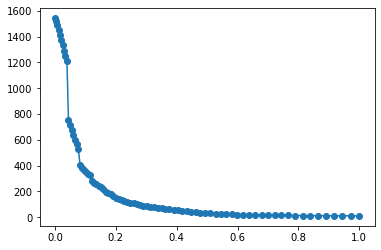

In [21]:
plt.plot(DI.ds['zeta_c_exp_model'].values, DI.age_misfit_statsDict['Misfit norm in each layer normalized by number of not NaNs in each layer'])
plt.scatter(DI.ds['zeta_c_exp_model'].values, DI.age_misfit_statsDict['Misfit norm in each layer normalized by number of not NaNs in each layer'])

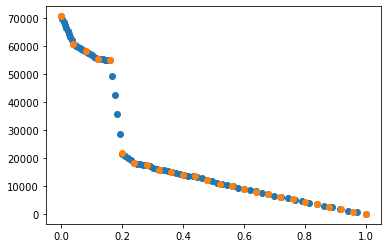

In [22]:
plt.scatter(DI.ds['zeta_c_exp_model'], DI.ds['age_norm_TopLayerAdded_Reversed_2D_interp_z_interp_linear'][:,100,180])
plt.scatter(np.linspace(0., 1., len(DI.ds['number of vertical layers with top layer added'])),DI.ds['age_norm_TopLayerAdded_Reversed_2D_interp'][:,100,180])

In [98]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 16})

def plot_data_model_thick(DI, AN):
    
    fig, ax = plt.subplots(1,3)
    
    im1 = ax[0].contourf(DI.ds[f'thick_2D_interp'].T, levels = 100, cmap = 'RdBu_r', vmin = 0, vmax = 3500)
    
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    
    im2 = ax[1].contourf(AN1.ds.variables[f'H'], levels = 100, cmap = 'RdBu_r', vmin = 0, vmax = 3500)
    
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')
    
    diff = DI.ds[f'thick_2D_interp'].values.T - AN1.ds.variables[f'H'].values
    im3 = ax[2].contourf(diff, levels = 100, cmap = 'RdBu_r', vmin = -2000, vmax = 2000)

    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical')

    plt.suptitle(f"Comparison of data and model ice thickness")
    ax[0].set_title("Data")
    ax[1].set_title("Model")
    ax[2].set_title("Data - Model")
    plt.tight_layout()

    return None

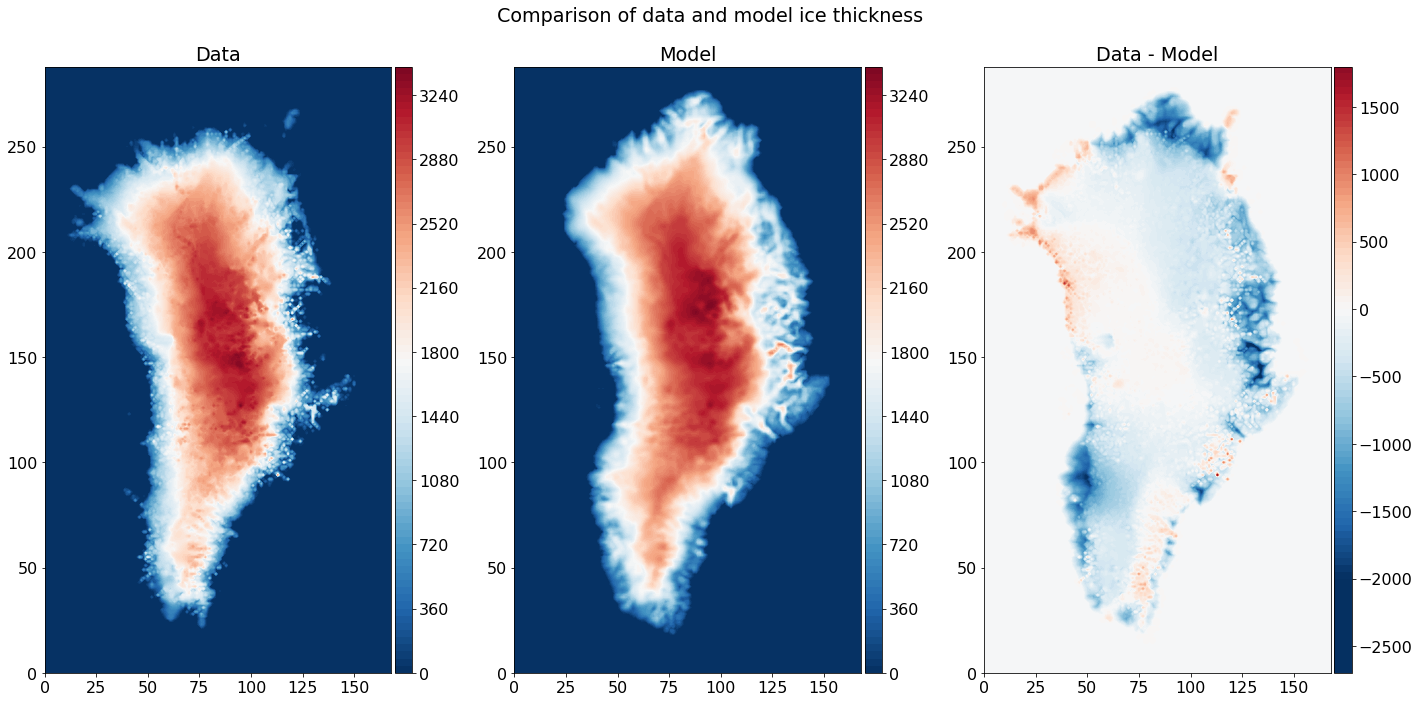

In [99]:
plot_data_model_thick(DI, AN1)

In [86]:
def plot_data_model_contours(DI, AN, contour_value):
    
    fig, ax = plt.subplots(1,3)
    
    DI.contours(contour_value, 
            'age_norm_TopLayerAdded_Reversed_2D_interp_z_interp_linear',
            'zeta_c_exp_model',
            'thick_2D_interp',
            kind = 'linear')
    im1 = ax[0].contourf(DI.ds[f'age_norm_TopLayerAdded_Reversed_2D_interp_z_interp_linear_contour_{contour_value}'].T, levels = 100, cmap = 'RdBu_r', vmin = 0, vmax = 3500)
    
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    
    AN.contours(contour_value, 'age_c', 'sigma_level_c', 'H', kind = 'linear')
    im2 = ax[1].contourf(AN1.ds.variables[f'age_c_contour_{contour_value}'], levels = 100, cmap = 'RdBu_r', vmin = 0, vmax = 3500)
    
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')
    
    diff = DI.ds[f'age_norm_TopLayerAdded_Reversed_2D_interp_z_interp_linear_contour_{contour_value}'].values.T - AN1.ds.variables[f'age_c_contour_{contour_value}'].values
    im3 = ax[2].contourf(diff, levels = 100, cmap = 'RdBu_r', vmin = -2000, vmax = 2000)

    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical')

    plt.suptitle(f"Comparison of data and model contour for age {contour_value}")
    ax[0].set_title("Data")
    ax[1].set_title("Model")
    ax[2].set_title("Data - Model")
    plt.tight_layout()

    return None

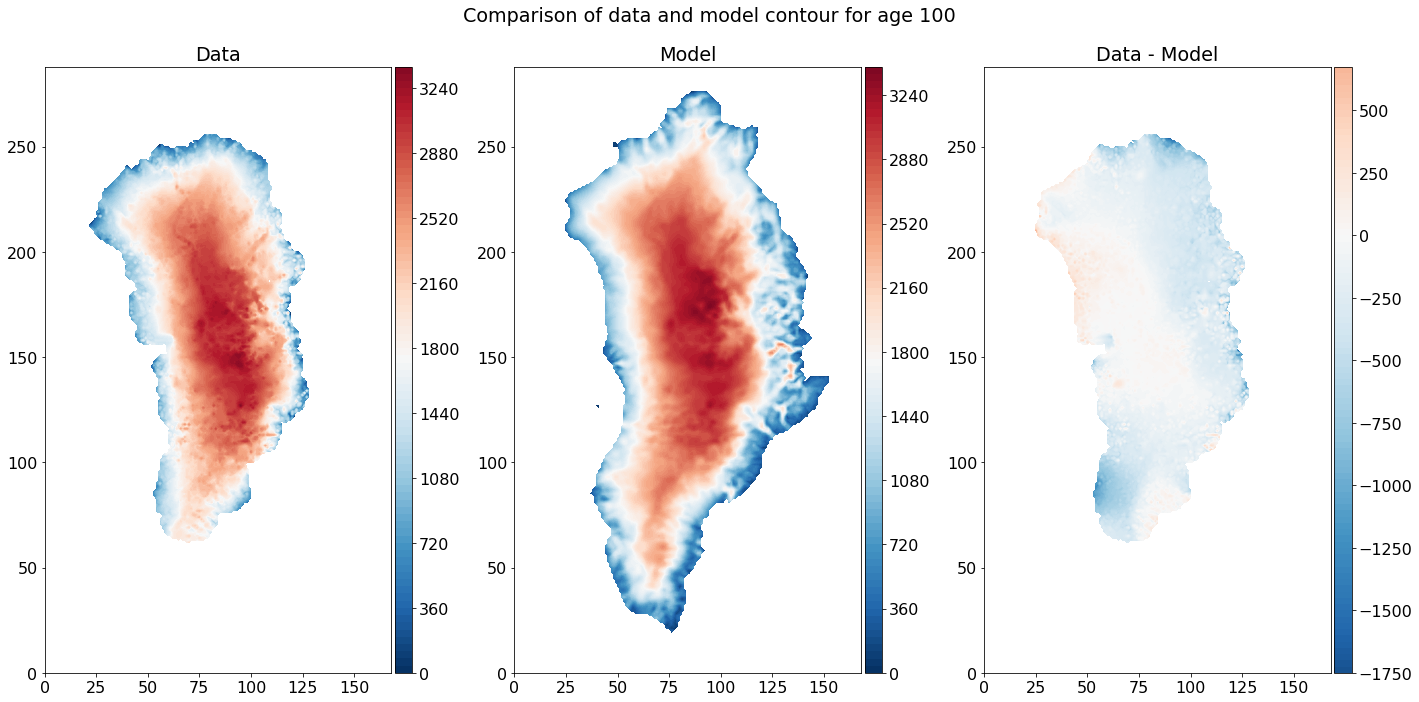

In [87]:
plot_data_model_contours(DI, AN1, 100)

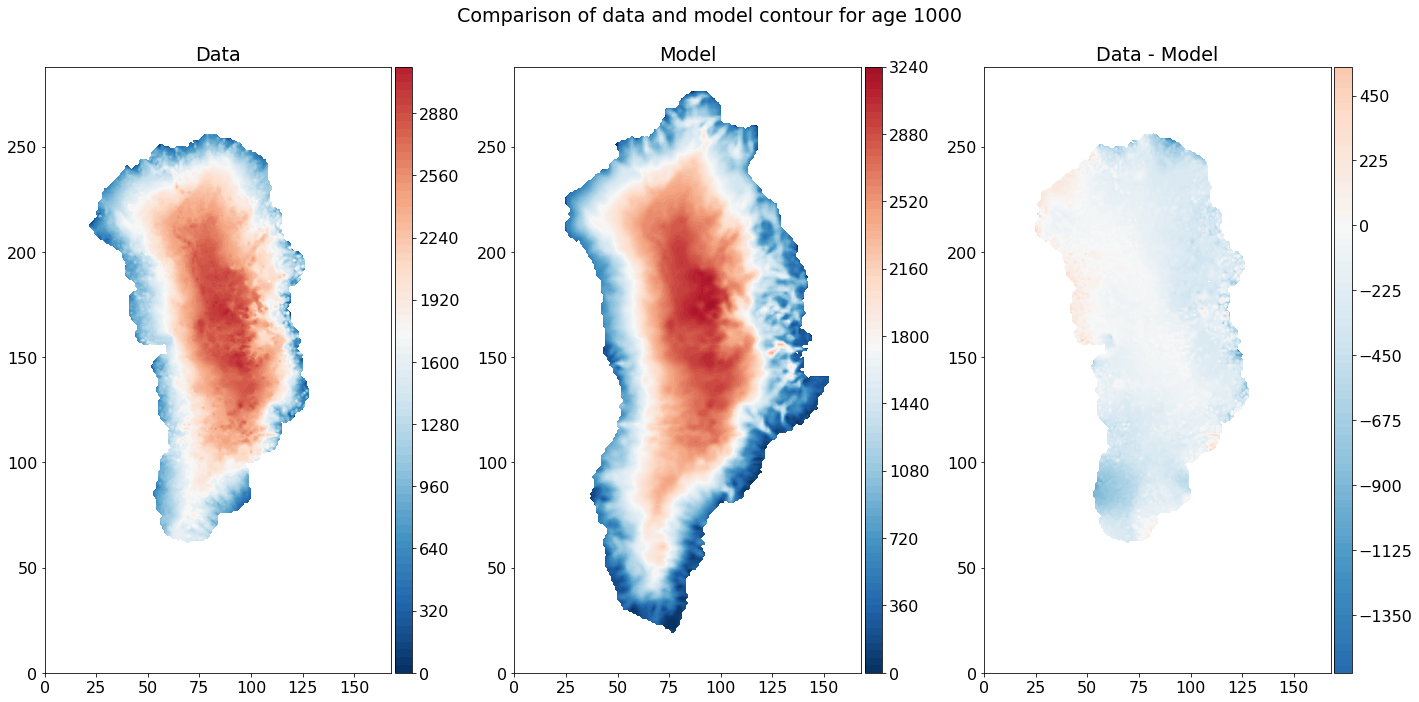

In [88]:
plot_data_model_contours(DI, AN1, 1000)

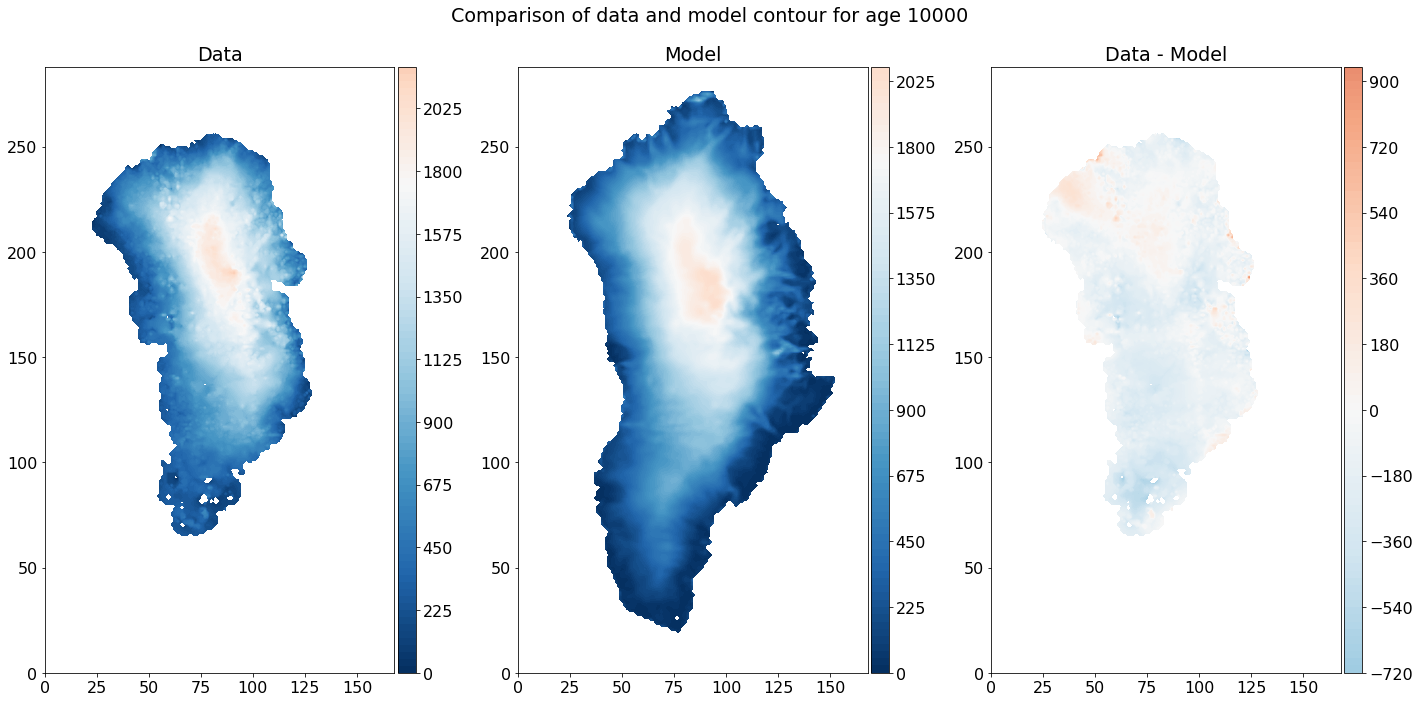

In [89]:
plot_data_model_contours(DI, AN1, 10000)

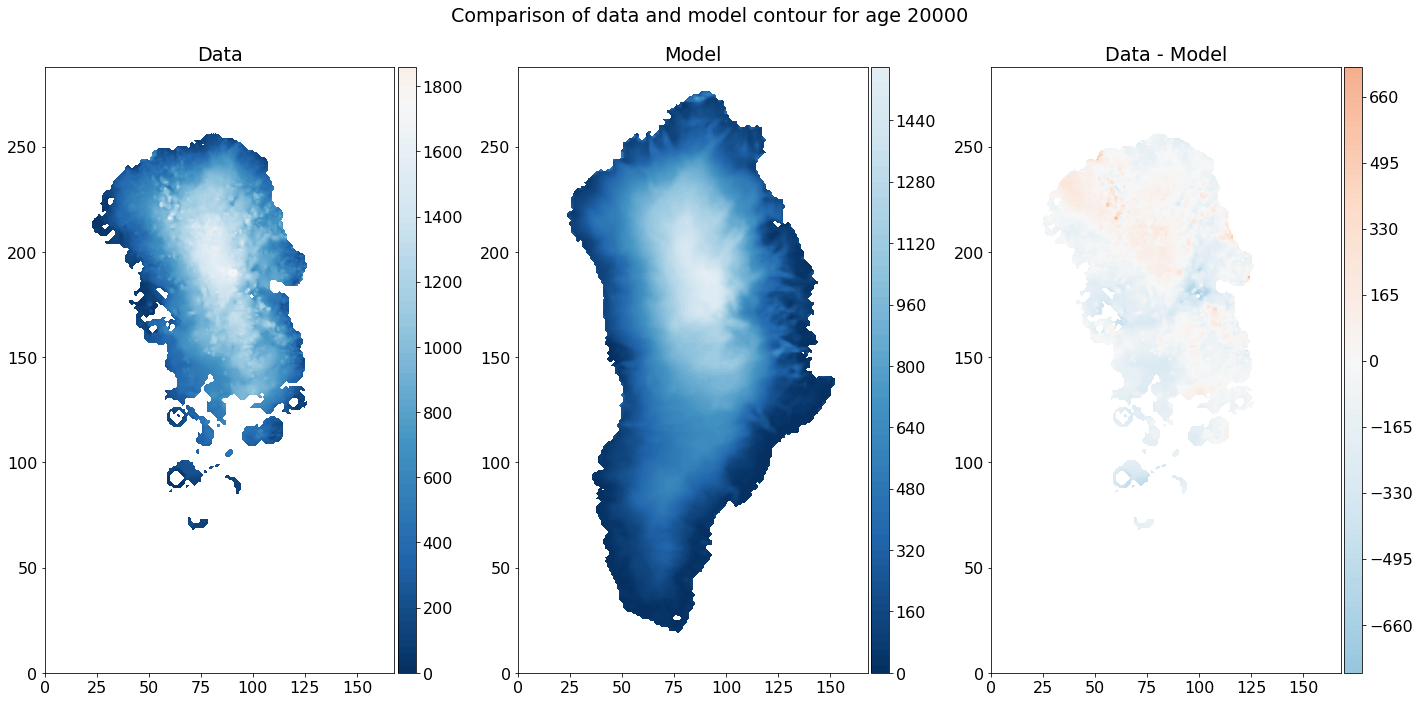

In [90]:
plot_data_model_contours(DI, AN1, 20000)

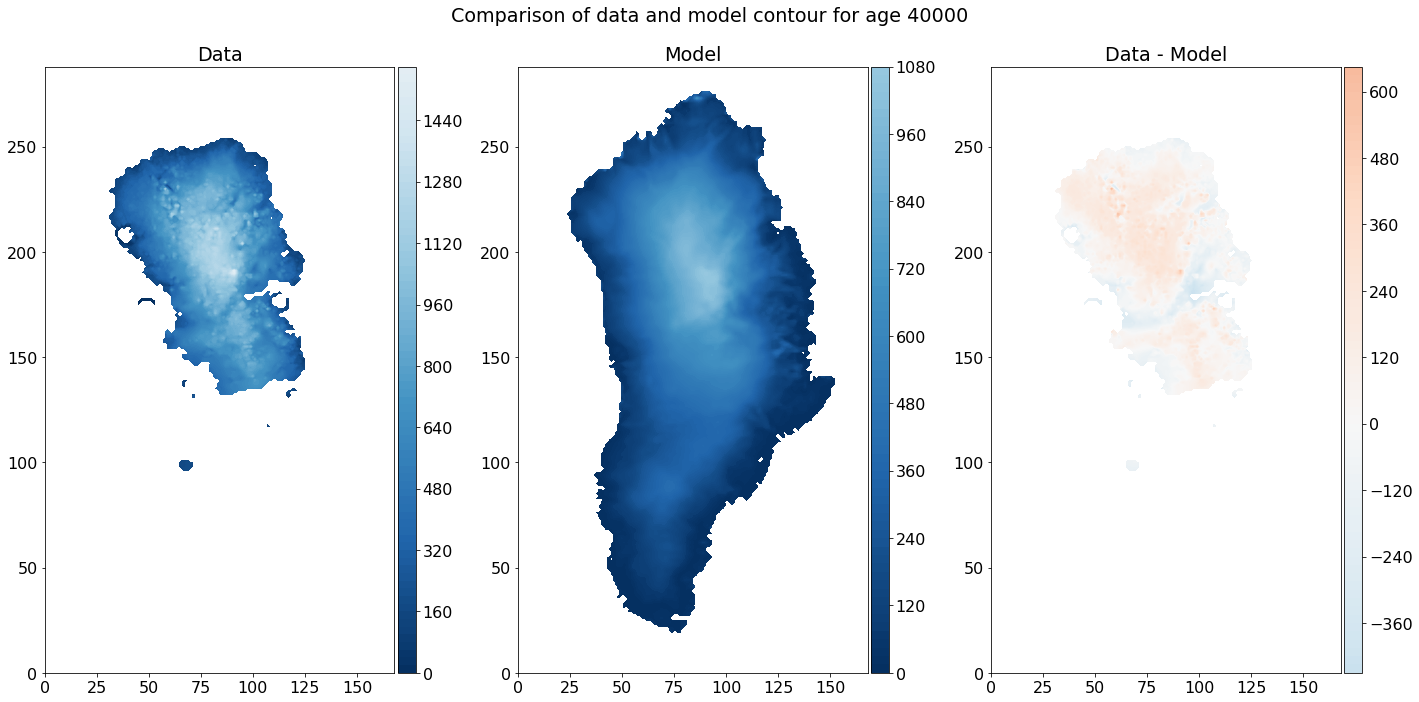

In [91]:
plot_data_model_contours(DI, AN1, 40000)

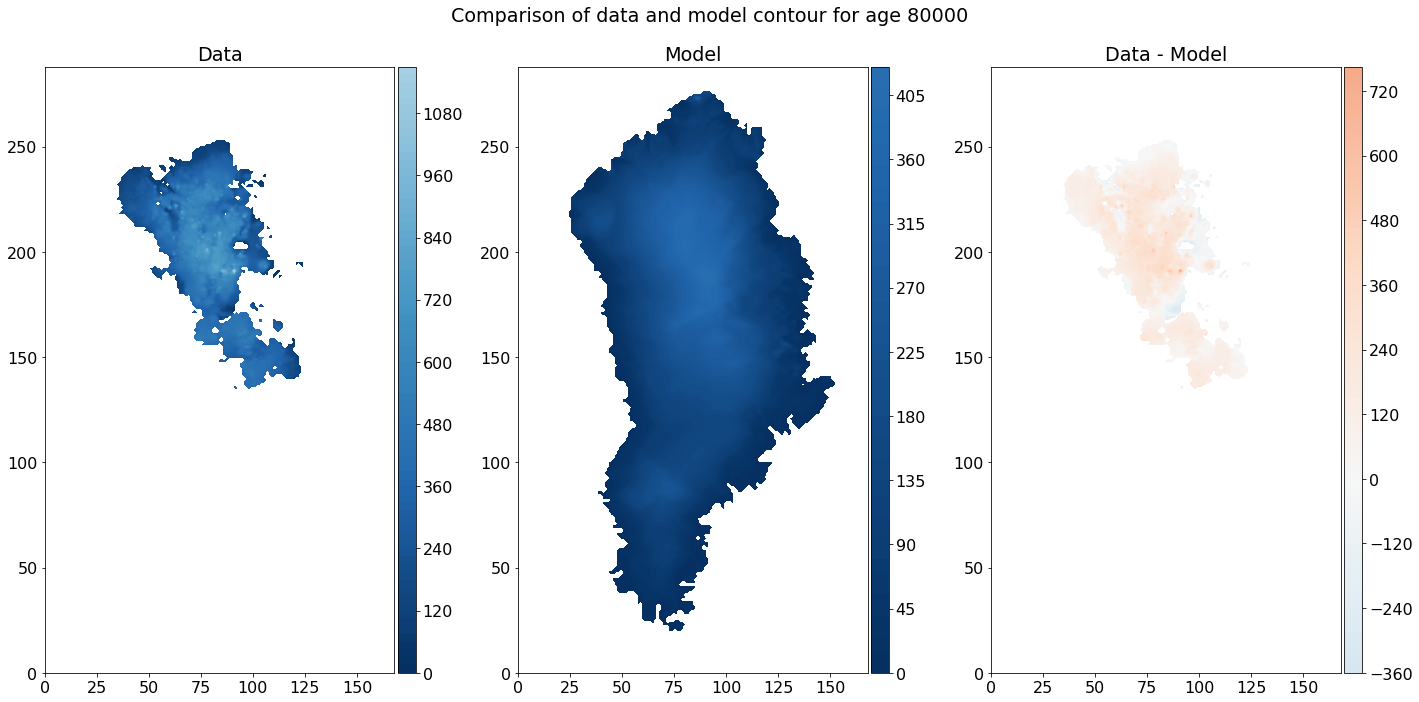

In [92]:
plot_data_model_contours(DI, AN1, 80000)